<table style="width:100%">
<tr>
<td style="vertical-align:middle; text-align:left;">
<font size="2">
以下代码为 <a href="http://mng.bz/orYv">《从零开始构建大型语言模型》</a> 一书的补充代码，作者为 <a href="https://sebastianraschka.com">Sebastian Raschka</a><br>
<br>中文翻译和代码详细注释由Lux整理，Github下载地址：<a href="https://github.com/luxianyu">https://github.com/luxianyu</a>
    
<br>Lux的Github上还有吴恩达深度学习Pytorch版学习笔记及中文详细注释的代码下载
    
</font>
</td>
<td style="vertical-align:middle; text-align:left;">
<a href="http://mng.bz/orYv"><img src="https://sebastianraschka.com/images/LLMs-from-scratch-images/cover-small.webp" width="100px"></a>
</td>
</tr>
</table>


# 第5章：在无标签数据上进行预训练


In [1]:
# -------------------------------------------------
# 导入函数 version，用于获取已安装包的版本号
# -------------------------------------------------
from importlib.metadata import version

# -------------------------------------------------
# 定义要查询版本号的包列表
# 包括：
# - matplotlib: 绘图库
# - numpy: 科学计算库
# - tiktoken: OpenAI tokenizer 库
# - torch: PyTorch 深度学习框架
# - tensorflow: TensorFlow，用于加载 OpenAI 预训练权重
# -------------------------------------------------
pkgs = ["matplotlib", 
        "numpy", 
        "tiktoken", 
        "torch",
        "tensorflow"
       ]

# -------------------------------------------------
# 遍历包列表
# -------------------------------------------------
for p in pkgs:
    # 调用 version(p) 获取包 p 的版本号
    # f-string 格式化输出包名和对应版本
    print(f"{p} version: {version(p)}")


matplotlib version: 3.10.0
numpy version: 2.1.3
tiktoken version: 0.12.0
torch version: 2.9.0+cpu
tensorflow version: 2.20.0


- 本章中，我们将实现训练循环和基本模型评估代码，以对大型语言模型（LLM）进行预训练  
- 在本章末，我们还将从 OpenAI 加载公开可用的预训练权重到我们的模型中


<img src="https://sebastianraschka.com/images/LLMs-from-scratch-images/ch05_compressed/01.webp" width=500px>

- 本章涵盖的主题如下所示


<img src="https://sebastianraschka.com/images/LLMs-from-scratch-images/ch05_compressed/02.webp" width=400px>

## 5.1 生成式文本模型的评估


- 本节我们首先回顾如何使用上一章的代码来初始化一个 GPT 模型。  
- 接着，我们将讨论用于评估大型语言模型（LLMs）的基本评价指标。  
- 最后，在本节中，我们将把这些评价指标应用到训练集和验证集上。


### 5.1.1 使用 GPT 生成文本


- 我们使用上一章的代码初始化一个 GPT 模型


In [2]:
# -------------------------------------------------
# 导入 PyTorch
# -------------------------------------------------
import torch

# -------------------------------------------------
# 从前面章节的模块导入 GPTModel 类
# -------------------------------------------------
from previous_chapters import GPTModel

# 如果本地没有 previous_chapters.py 文件，也可以从 PyPI 安装的 llms-from-scratch 包导入
# 例如：
# from llms_from_scratch.ch04 import GPTModel
# 详细信息请参考：https://github.com/rasbt/LLMs-from-scratch/tree/main/pkg

# -------------------------------------------------
# 定义 GPT 模型的配置信息
# -------------------------------------------------
GPT_CONFIG_124M = {
    "vocab_size": 50257,    # 词汇表大小（token 总数）
    "context_length": 256,  # 最大上下文长度（原始 GPT-124M 模型为 1024，此处为了演示缩短为 256）
    "emb_dim": 768,         # token embedding 的维度
    "n_heads": 12,          # 多头注意力的头数
    "n_layers": 12,         # Transformer 层数
    "drop_rate": 0.1,       # dropout 概率
    "qkv_bias": False       # Query/Key/Value 是否使用 bias
}

# -------------------------------------------------
# 设置随机种子，确保实验可复现
# -------------------------------------------------
torch.manual_seed(123)

# -------------------------------------------------
# 创建 GPT 模型实例
# -------------------------------------------------
model = GPTModel(GPT_CONFIG_124M)

# -------------------------------------------------
# 设置模型为评估模式（evaluation mode），
# 关闭 dropout 等训练专用操作
# -------------------------------------------------
model.eval()


GPTModel(
  (tok_emb): Embedding(50257, 768)
  (pos_emb): Embedding(256, 768)
  (drop_emb): Dropout(p=0.1, inplace=False)
  (trf_blocks): Sequential(
    (0): TransformerBlock(
      (att): MultiHeadAttention(
        (W_query): Linear(in_features=768, out_features=768, bias=False)
        (W_key): Linear(in_features=768, out_features=768, bias=False)
        (W_value): Linear(in_features=768, out_features=768, bias=False)
        (out_proj): Linear(in_features=768, out_features=768, bias=True)
        (dropout): Dropout(p=0.1, inplace=False)
      )
      (ff): FeedForward(
        (layers): Sequential(
          (0): Linear(in_features=768, out_features=3072, bias=True)
          (1): GELU()
          (2): Linear(in_features=3072, out_features=768, bias=True)
        )
      )
      (norm1): LayerNorm()
      (norm2): LayerNorm()
      (drop_shortcut): Dropout(p=0.1, inplace=False)
    )
    (1): TransformerBlock(
      (att): MultiHeadAttention(
        (W_query): Linear(in_features

- 在上面的代码中，我们使用了 0.1 的 dropout，但如今训练 LLM 时通常并不会使用 dropout。  
- 现代 LLM 在查询（query）、键（key）和值（value）矩阵对应的 `nn.Linear` 层中也不再使用偏置向量（bias vectors），这与早期的 GPT 模型不同，可以通过设置 `"qkv_bias": False` 来实现。  
- 我们将上下文长度（`context_length`）缩减为 256 个 token，以降低训练模型所需的计算资源；而原始的 1.24 亿参数 GPT-2 模型使用的是 1024 个 token。  
  - 这样做的目的是让更多读者能够在笔记本电脑上运行并理解代码示例。  
  - 当然，你也可以将 `context_length` 增加到 1024（无需修改其他代码）。  
  - 我们稍后还会从预训练权重中加载一个使用 1024 `context_length` 的模型。


- 接下来，我们将使用上一章的 `generate_text_simple` 函数来生成文本。  
- 此外，我们还定义了两个便捷函数：`text_to_token_ids` 和 `token_ids_to_text`，用于在 token 表示与文本表示之间进行转换，这两个函数将在本章中多次使用。


<img src="https://sebastianraschka.com/images/LLMs-from-scratch-images/ch05_compressed/03.webp" width=500px>

In [3]:
# -------------------------------------------------
# 导入 tiktoken 用于 GPT-2 Tokenizer
# -------------------------------------------------
import tiktoken

# 导入之前章节中实现的简单文本生成函数
from previous_chapters import generate_text_simple
# 或者，如果使用 PyPI 包：
# from llms_from_scratch.ch04 import generate_text_simple

# -------------------------------------------------
# 定义一个函数：将文本转为 token id 张量
# -------------------------------------------------
def text_to_token_ids(text, tokenizer):
    """
    输入：
        text: 待编码的字符串
        tokenizer: tiktoken tokenizer 对象
    输出：
        encoded_tensor: [1, n_tokens] 的 LongTensor，添加了 batch 维度
    """
    # encode 将文本转换为 token id 列表
    encoded = tokenizer.encode(text, allowed_special={'<|endoftext|>'})
    # 转换为 tensor，并增加 batch 维度 (1, n_tokens)
    encoded_tensor = torch.tensor(encoded).unsqueeze(0)
    return encoded_tensor

# -------------------------------------------------
# 定义一个函数：将 token id 张量转回文本
# -------------------------------------------------
def token_ids_to_text(token_ids, tokenizer):
    """
    输入：
        token_ids: [1, n_tokens] 或 [n_tokens] 的张量
        tokenizer: tiktoken tokenizer 对象
    输出：
        text: 解码后的字符串
    """
    # 压缩 batch 维度，[1, n_tokens] -> [n_tokens]
    flat = token_ids.squeeze(0)
    # 转为列表并解码
    return tokenizer.decode(flat.tolist())

# -------------------------------------------------
# 设置初始文本
# -------------------------------------------------
start_context = "Every effort moves you"

# 创建 GPT-2 tokenizer 对象
tokenizer = tiktoken.get_encoding("gpt2")

# -------------------------------------------------
# 使用简单生成函数生成新 token
# -------------------------------------------------
token_ids = generate_text_simple(
    model=model,  # GPT 模型对象
    idx=text_to_token_ids(start_context, tokenizer),  # 将初始文本转换为 tensor
    max_new_tokens=10,  # 新生成 token 数量
    context_size=GPT_CONFIG_124M["context_length"]  # 使用的上下文长度
)

# -------------------------------------------------
# 将生成的 token id 转换回文本
# -------------------------------------------------
print("Output text:\n", token_ids_to_text(token_ids, tokenizer))


Output text:
 Every effort moves you rentingetic wasnم refres RexMeCHicular stren


- 正如上面所看到的，模型生成的文本效果并不好，因为它尚未经过训练。  
- 那么，我们该如何用数值的方式来衡量或捕捉“好文本”的概念，以便在训练过程中进行跟踪呢？  
- 接下来的小节将介绍用于计算生成输出损失指标（loss metric）的方法，我们可以通过该指标来衡量训练的进展。  
- 而在后续关于微调 LLM 的章节中，我们还将介绍更多用于评估模型质量的指标。


<br>

### 5.1.2 Calculating the text generation loss: cross-entropy and perplexity

- 假设我们有一个名为 `inputs` 的张量，其中包含两个训练样本（行）的 token ID。  
- 与 `inputs` 对应的 `targets` 张量中，存放的是我们希望模型生成的目标 token ID。  
- 请注意，`targets` 是由 `inputs` 向右平移一个位置得到的，这一点我们在第 2 章实现数据加载器（data loader）时已经解释过。


In [4]:
# -------------------------------------------------
# 定义示例输入序列
# 每一行代表一个训练样本，每个数字是一个 token id
# -------------------------------------------------
inputs = torch.tensor([
    [16833, 3626, 6100],   # 第 1 个样本对应的 token 序列 ["every", "effort", "moves"]
    [40,    1107, 588]     # 第 2 个样本对应的 token 序列 ["I", "really", "like"]
])

# -------------------------------------------------
# 定义对应的目标序列（即下一个 token 的标签）
# 每一行对应 inputs 的下一个 token 预测目标
# -------------------------------------------------
targets = torch.tensor([
    [3626, 6100, 345],     # 第 1 个样本的目标 token id ["effort", "moves", "you"]
    [1107, 588, 11311]     # 第 2 个样本的目标 token id ["really", "like", "chocolate"]
])

# -------------------------------------------------
# 输出输入与目标张量的形状及内容
# -------------------------------------------------
print("Inputs shape:", inputs.shape)   # (batch_size=2, seq_len=3)
print("Targets shape:", targets.shape) # (batch_size=2, seq_len=3)
print("\nInputs:\n", inputs)
print("\nTargets:\n", targets)


Inputs shape: torch.Size([2, 3])
Targets shape: torch.Size([2, 3])

Inputs:
 tensor([[16833,  3626,  6100],
        [   40,  1107,   588]])

Targets:
 tensor([[ 3626,  6100,   345],
        [ 1107,   588, 11311]])


- 将 `inputs` 输入模型后，我们会得到对应的 logits 向量，对于这两个输入样本而言，每个样本包含 3 个 token。  
- 每个 token 都对应一个 50,257 维的向量，这个维度大小与词汇表（vocabulary）的大小相同。  
- 通过对 logits 张量应用 softmax 函数，我们可以将其转换为相同维度的张量，其中包含每个 token 的概率分数。


In [5]:
# -------------------------------
# 在推理模式下计算 logits（不计算梯度）
# -------------------------------
with torch.no_grad():  # 禁用梯度计算，提高效率，推理/生成时通常使用
    logits = model(inputs)  
    # logits 形状: [batch_size, seq_len, vocab_size]
    # - batch_size: 样本数量，这里是 2
    # - seq_len: 输入序列长度，这里是 3
    # - vocab_size: 模型词汇表大小（例如 GPT-124M 是 50257）
    # logits 中每个位置的向量表示该 token 在词表中每个词的得分（未归一化）
    
# -------------------------------
# 将 logits 转换为概率
# -------------------------------
probas = torch.softmax(logits, dim=-1)  
# softmax 说明：
# - dim=-1 表示在最后一个维度上归一化，也就是对每个 token 的 vocab_size 个得分进行 softmax
# - 输出 probas 形状与 logits 相同: [batch_size, seq_len, vocab_size]
# - probas[i,j,k] 表示第 i 个样本，第 j 个 token 对应词表第 k 个词的预测概率

# -------------------------------
# 查看概率张量形状
# -------------------------------
print(probas.shape)  
# 输出结果: torch.Size([2, 3, 50257])
# - batch_size=2，seq_len=3，vocab_size=50257


torch.Size([2, 3, 50257])


- 下图使用非常小的词汇表进行示例，概述了我们如何将概率分数转换回文本，这一点在上一章末尾已经讨论过：


<img src="https://sebastianraschka.com/images/LLMs-from-scratch-images/ch05_compressed/04.webp" width=500px>

- 正如上一章所讨论的，我们可以使用 `argmax` 函数将概率分数转换为预测的 token ID。  
- 上述 softmax 函数为每个 token 生成了一个 50,257 维的向量；`argmax` 函数则返回该向量中概率最高的位置索引，即该 token 的预测 ID。


- 由于我们有2个输入批次（batch），每个批次包含3个标记，因此我们得到一个 2×3 的预测标记 ID：


In [5]:
# -------------------------------
# 使用模型生成 logits，但不计算梯度
# -------------------------------
# torch.no_grad() 可以关闭梯度计算，节省内存和加速推理
with torch.no_grad():
    logits = model(inputs)  # logits 形状为 [batch_size, seq_len, vocab_size]

# -------------------------------
# 将 logits 转换为每个 token 的概率分布
# -------------------------------
# softmax 沿最后一维 dim=-1，将 logits 转为概率分布
# 每个 token 在词表中每个位置的概率之和为 1
probas = torch.softmax(logits, dim=-1)

# 输出概率张量的形状
# shape: [batch_size, seq_len, vocab_size]
print("Probas shape:", probas.shape)

# -------------------------------
# 获取概率最大的位置索引，即预测的 token id
# -------------------------------
# torch.argmax: 返回沿指定维度最大值的索引
# dim=-1 表示在词表维度上取最大值
# keepdim=True 保持维度，方便后续操作
token_ids = torch.argmax(probas, dim=-1, keepdim=True)

# 输出预测的 token ids
print("Token IDs:\n", token_ids)


Probas shape: torch.Size([2, 3, 50257])
Token IDs:
 tensor([[[16657],
         [  339],
         [42826]],

        [[49906],
         [29669],
         [41751]]])


- 如果我们对这些标记进行解码，会发现它们与我们希望模型预测的标记（即目标标记）有很大差异：


In [6]:
# -------------------------------
# 打印第一条样本的目标文本
# -------------------------------
# targets[0] 取第一条样本的 target token IDs，形状 [seq_len]
# token_ids_to_text 函数将 token ID 列表解码为可读文本
print(f"Targets batch 1: {token_ids_to_text(targets[0], tokenizer)}")

# -------------------------------
# 打印第一条样本模型预测输出的文本
# -------------------------------
# token_ids[0] 取第一条样本的预测 token IDs，形状 [seq_len, 1]
# flatten() 将 [seq_len,1] 压缩为 [seq_len]，方便解码
# token_ids_to_text 将 token IDs 解码为文本
print(f"Outputs batch 1: {token_ids_to_text(token_ids[0].flatten(), tokenizer)}")


Targets batch 1:  effort moves you
Outputs batch 1:  Armed heNetflix


- 这是因为模型尚未经过训练  
- 为了训练模型，我们需要知道它与正确预测（目标值）之间的差距


<img src="https://sebastianraschka.com/images/LLMs-from-scratch-images/ch05_compressed/06.webp" width=500px>

- 与目标索引对应的标记概率如下：


In [7]:
# -------------------------------
# 选择 batch 中的第一条文本（索引 0）
# -------------------------------
text_idx = 0

# probas 的 shape 是 [batch_size, num_tokens, vocab_size]
# targets[text_idx] 是第一条文本的目标 token IDs, shape [num_tokens]
# probas[text_idx, [0,1,2], targets[text_idx]] 
#   - [0,1,2] 指明选取第一条文本的每个 token 位置
#   - targets[text_idx] 给出对应位置的正确 token ID
#   - 结果是第一条文本每个目标 token 的预测概率
target_probas_1 = probas[text_idx, [0, 1, 2], targets[text_idx]]
print("Text 1:", target_probas_1)

# -------------------------------
# 选择 batch 中的第二条文本（索引 1）
# -------------------------------
text_idx = 1

# 同理，获取第二条文本每个目标 token 的预测概率
target_probas_2 = probas[text_idx, [0, 1, 2], targets[text_idx]]
print("Text 2:", target_probas_2)


Text 1: tensor([7.4541e-05, 3.1061e-05, 1.1563e-05])
Text 2: tensor([1.0337e-05, 5.6776e-05, 4.7559e-06])


- 我们希望最大化所有这些值，使它们尽可能接近概率 1。  
- 在数学优化中，最大化概率的对数（logarithm of the probability）要比直接最大化概率本身更容易实现；这一部分超出了本书的讨论范围，但我在这里录制了一段更详细的讲解视频：[L8.2 Logistic Regression Loss Function](https://www.youtube.com/watch?v=GxJe0DZvydM)。


In [8]:
# -------------------------------
# 将第一条文本和第二条文本的目标 token 概率拼接在一起
# torch.cat 默认沿第 0 维拼接，即将两个一维张量连接成一个一维张量
# -------------------------------
all_target_probas = torch.cat((target_probas_1, target_probas_2))

# -------------------------------
# 对拼接后的目标 token 概率取自然对数
# log(p) 是计算交叉熵损失或负对数似然的关键步骤
# -------------------------------
log_probas = torch.log(all_target_probas)

# 打印结果
print(log_probas)


tensor([ -9.5042, -10.3796, -11.3677, -11.4798,  -9.7764, -12.2561])


- 接下来，我们计算平均对数概率：


In [9]:
# -------------------------------
# 计算所有目标 token log-probabilities 的平均值
# torch.mean() 会将张量中的所有元素取平均
# -------------------------------
avg_log_probas = torch.mean(log_probas)

# 打印结果
print(avg_log_probas)


tensor(-10.7940)


- 我们的目标是通过优化模型权重，使这个平均对数概率（average log probability）尽可能大。  
- 由于取了对数，理论上的最大值为 0，而当前模型的结果距离 0 仍然相差较远。


- 在深度学习中，我们通常不会直接最大化平均对数概率（average log-probability），而是遵循标准做法，最小化其“负的平均对数概率”值。  
  在我们的例子中，与其最大化 -10.7722 使其接近 0，不如最小化 10.7722 使其接近 0。  
- 这个 -10.7722 的相反数（即 10.7722）在深度学习中也被称为 **交叉熵损失（cross-entropy loss）**。


In [10]:
# -------------------------------
# 将平均对数概率取负
# -------------------------------
neg_avg_log_probas = avg_log_probas * -1

# 打印结果
print(neg_avg_log_probas)


tensor(10.7940)


- PyTorch 已经实现了一个 `cross_entropy` 函数，用于执行上述步骤


<img src="https://sebastianraschka.com/images/LLMs-from-scratch-images/ch05_compressed/07.webp" width=400px>

- 在应用 `cross_entropy` 函数之前，我们先检查 logits 和目标值（targets）的形状


In [11]:
# --------------------------------------
# 打印 logits 的形状
# logits 是模型输出的原始分数（未经过 softmax）
# 形状为 (batch_size, num_tokens, vocab_size)
# - batch_size: 批量中样本数量
# - num_tokens: 每个样本中的 token 数量（序列长度）
# - vocab_size: 模型词表大小（每个 token 的预测分布）
# --------------------------------------
print("Logits shape:", logits.shape)

# --------------------------------------
# 打印目标 targets 的形状
# targets 是对应的真实 token 索引
# 形状为 (batch_size, num_tokens)
# - batch_size: 批量中样本数量
# - num_tokens: 每个样本中的 token 数量
# --------------------------------------
print("Targets shape:", targets.shape)


Logits shape: torch.Size([2, 3, 50257])
Targets shape: torch.Size([2, 3])


- 对于 PyTorch 中的 `cross_entropy` 函数，我们需要将这些张量在批量维度上展开（flatten）：


In [12]:
# ---------------------------------------------------
# 将 logits 展平 (flatten) 以便计算交叉熵损失
# logits 的原始形状为 (batch_size, num_tokens, vocab_size)
# flatten(0, 1) 表示把第 0 维（batch_size）和第 1 维（num_tokens）合并为一维
# 结果形状为 (batch_size * num_tokens, vocab_size)
# ---------------------------------------------------
logits_flat = logits.flatten(0, 1)

# ---------------------------------------------------
# 将 targets 展平
# targets 原始形状为 (batch_size, num_tokens)
# flatten() 将其展平为 (batch_size * num_tokens,)
# 这样可以和展平后的 logits 一一对应，用于计算交叉熵损失
# ---------------------------------------------------
targets_flat = targets.flatten()

# ---------------------------------------------------
# 打印展平后的 logits 和 targets 的形状
# logits_flat: (batch_size * num_tokens, vocab_size)
# targets_flat: (batch_size * num_tokens,)
# ---------------------------------------------------
print("Flattened logits:", logits_flat.shape)
print("Flattened targets:", targets_flat.shape)


Flattened logits: torch.Size([6, 50257])
Flattened targets: torch.Size([6])


- 注意，`targets` 是 token ID，同时也表示我们希望在 logits 张量中最大化的索引位置。  
- PyTorch 中的 `cross_entropy` 函数会自动处理 softmax 和对数概率（log-probability）的计算，并在 logits 中对应的 token 索引上进行优化。


In [13]:
# ---------------------------------------------------
# 使用 PyTorch 的函数式接口计算交叉熵损失
# logits_flat: 展平后的模型输出，形状为 (batch_size * num_tokens, vocab_size)
# targets_flat: 展平后的目标 token IDs，形状为 (batch_size * num_tokens,)
# torch.nn.functional.cross_entropy 会对 logits 自动做 softmax，并计算每个 token 的负对数似然
# ---------------------------------------------------
loss = torch.nn.functional.cross_entropy(logits_flat, targets_flat)

# ---------------------------------------------------
# 打印交叉熵损失值
# loss 是一个标量张量，表示 batch 内所有 token 的平均负对数似然
# 值越小，表示模型预测越接近目标
# ---------------------------------------------------
print(loss)


tensor(10.7940)


- 与交叉熵损失相关的一个概念是大型语言模型（LLM）的困惑度（perplexity）  
- 困惑度就是交叉熵损失的指数值


In [14]:
# ---------------------------------------------------
# 困惑度（Perplexity）计算
# 困惑度是语言模型常用的评价指标，它衡量模型对目标序列的不确定性
# 对于 N 个 token 的平均负对数似然 loss，perplexity 定义为：
#   perplexity = exp(loss)
# loss 越小，perplexity 越接近 1，表示模型越“自信”，预测越准确
# ---------------------------------------------------
perplexity = torch.exp(loss)

# ---------------------------------------------------
# 打印困惑度
# 这是一个标量，越小表示模型性能越好
# ---------------------------------------------------
print(perplexity)


tensor(48725.8203)


- 困惑度（perplexity）通常被认为更易于理解，因为它可以被看作模型在每一步对词汇表的不确定性有效大小（在上面的例子中，即 48,725 个单词或 token）。  
- 换句话说，困惑度衡量了模型预测的概率分布与数据集中单词的实际分布匹配的程度。  
- 类似于损失（loss），较低的困惑度表示模型的预测更接近实际分布。


### 5.1.3 计算训练集和验证集损失


- 我们使用了一个相对较小的数据集来训练 LLM（实际上只有一个短篇故事）。  
- 原因如下：  
  - 你可以在笔记本电脑上几分钟内运行代码示例，无需配备合适的 GPU。  
  - 训练速度相对较快（几分钟而不是几周），这对教学目的非常适合。  
  - 我们使用的是公共领域（public domain）的文本，可以安全地包含在 GitHub 仓库中，不会侵犯使用权，也不会使仓库体积过大。

- 举例来说，Llama 2 7B 在 2 万亿 token 上训练时，需要在 A100 GPU 上耗费 184,320 GPU 小时。  
  - 撰写本文时，AWS 上 8xA100 云服务器的小时费用大约为 \$30。  
  - 粗略计算，训练这个 LLM 的成本为 184,320 / 8 * \$30 = \$690,000。

- 下文中，我们使用与第 2 章相同的数据集。


In [15]:
# ===================================================
# 下载并读取文本文件
# 如果本地不存在指定文件，则从网络下载；否则直接读取本地文件
# ===================================================

import os       # 用于文件路径检查
import requests # 用于发送 HTTP 请求

# ---------------------------------------------------
# 设置文件名和下载 URL
# file_path: 本地文件名
# url: 网络资源地址（原书中的文本文件）
# ---------------------------------------------------
file_path = "the-verdict.txt"
url = "https://raw.githubusercontent.com/rasbt/LLMs-from-scratch/main/ch02/01_main-chapter-code/the-verdict.txt"

# ---------------------------------------------------
# 检查本地文件是否存在
# os.path.exists(file_path) 返回 True 表示文件已存在
# ---------------------------------------------------
if not os.path.exists(file_path):
    # 如果文件不存在，则通过 HTTP GET 请求下载文件
    response = requests.get(url, timeout=30)  # timeout=30 秒，防止网络阻塞
    response.raise_for_status()               # 如果请求失败（如 404/500），抛出异常
    text_data = response.text                 # 获取文本内容

    # 将下载的文本写入本地文件
    with open(file_path, "w", encoding="utf-8") as file:
        file.write(text_data)
else:
    # 如果文件已存在，则直接读取本地文件内容
    with open(file_path, "r", encoding="utf-8") as file:
        text_data = file.read()

# ---------------------------------------------------
# 说明：
# 原书中使用 urllib.request 下载文件：
#   import urllib.request
#   with urllib.request.urlopen(url) as response:
#       text_data = response.read().decode('utf-8')
# 但是 urllib 可能会遇到 VPN 或 TLS 协议问题。
# 使用 requests 更稳健、兼容性更好。
# ---------------------------------------------------


- 通过打印前99个和后99个字符，快速检查文本是否加载正确


In [16]:
# ---------------------------------------------------
# 打印文本的前 99 个字符，用于快速查看文件内容
# text_data: 前面下载或读取的完整文本字符串
# text_data[:99]: 切片操作，取从索引 0 到索引 98 的字符（总共 99 个字符）
# print(): 输出到屏幕
# ---------------------------------------------------
print(text_data[:99])


I HAD always thought Jack Gisburn rather a cheap genius--though a good fellow enough--so it was no 


In [17]:
# ---------------------------------------------------
# 打印文本的最后 99 个字符，用于快速查看文件结尾内容
# text_data: 前面下载或读取的完整文本字符串
# text_data[-99:]: 切片操作，取从倒数第 99 个字符到最后的所有字符
# print(): 输出到屏幕
# ---------------------------------------------------
print(text_data[-99:])


it for me! The Strouds stand alone, and happen once--but there's no exterminating our kind of art."


In [18]:
# ---------------------------------------------------
# 计算文本的总字符数和总 token 数量
# ---------------------------------------------------

# len(text_data)：返回字符串 text_data 的长度，即文本中的字符总数
total_characters = len(text_data)

# tokenizer.encode(text_data)：将文本编码为 token ID 列表
# len(...)：计算 token 列表的长度，即文本被分词后的 token 总数
total_tokens = len(tokenizer.encode(text_data))

# 打印总字符数
print("Characters:", total_characters)

# 打印总 token 数量
print("Tokens:", total_tokens)


Characters: 20479
Tokens: 5145


- 该文本共有 5,145 个标记（tokens），对于训练大型语言模型（LLM）来说非常短，但这只是用于教学目的（我们稍后还会加载预训练权重）


- 接下来，我们将数据集划分为训练集和验证集，并使用第 2 章的数据加载器（data loaders）来准备 LLM 训练的批次（batches）。  
- 为了可视化，下面的图假设 `max_length=6`，但在训练加载器中，我们将 `max_length` 设置为 LLM 所支持的上下文长度（context length）。  
- 下图仅为简化，仅展示了输入 token：  
  - 由于我们训练 LLM 以预测文本中的下一个单词，目标（targets）看起来与这些输入相同，只是目标向右平移了一个位置。


<img src="https://sebastianraschka.com/images/LLMs-from-scratch-images/ch05_compressed/09.webp" width=500px>

In [19]:
from previous_chapters import create_dataloader_v1
# 或者从 PyPI 包中导入：
# from llms_from_scratch.ch02 import create_dataloader_v1

# -------------------------------------------------------
# 设置训练集与验证集比例
# -------------------------------------------------------
train_ratio = 0.90  # 90% 数据用于训练，10% 用于验证
split_idx = int(train_ratio * len(text_data))  # 计算切分索引位置
train_data = text_data[:split_idx]            # 训练集数据
val_data = text_data[split_idx:]              # 验证集数据

# -------------------------------------------------------
# 设置随机种子，确保可复现
# -------------------------------------------------------
torch.manual_seed(123)

# =======================================================
# 创建训练集 DataLoader
# =======================================================
train_loader = create_dataloader_v1(
    train_data,                              # 原始文本训练数据
    batch_size=2,                             # 每个 batch 取 2 条样本
    max_length=GPT_CONFIG_124M["context_length"],  # 每条样本最大 token 长度
    stride=GPT_CONFIG_124M["context_length"],      # 步长（stride），这里等于 max_length，相当于不重叠
    drop_last=True,                           # 丢弃最后一个不足 batch_size 的 batch
    shuffle=True,                             # 打乱样本顺序，用于训练
    num_workers=0                              # DataLoader 的工作线程数（0 表示在主进程运行）
)

# =======================================================
# 创建验证集 DataLoader
# =======================================================
val_loader = create_dataloader_v1(
    val_data,                                # 原始文本验证数据
    batch_size=2,                             # 每个 batch 取 2 条样本
    max_length=GPT_CONFIG_124M["context_length"],  # 每条样本最大 token 长度
    stride=GPT_CONFIG_124M["context_length"],      # 步长
    drop_last=False,                          # 验证集不丢弃最后一个不足 batch_size 的 batch
    shuffle=False,                            # 验证集不打乱顺序
    num_workers=0                              # DataLoader 的工作线程数
)


In [20]:
# -------------------------------------------------------
# 检查训练集和验证集是否有足够的 token 来构建 DataLoader
# 防止 context_length 太大而导致某个 loader 没有足够 token
# -------------------------------------------------------

# 检查训练集 token 数量是否足够
if total_tokens * train_ratio < GPT_CONFIG_124M["context_length"]:
    print(
        "Not enough tokens for the training loader. "
        "Try to lower the `GPT_CONFIG_124M['context_length']` or "
        "increase the `training_ratio`"
    )
    # 解释：
    # total_tokens * train_ratio：训练集中的 token 总数
    # GPT_CONFIG_124M["context_length"]：模型支持的最大上下文长度
    # 如果训练集 token 数量小于 context_length，DataLoader 无法生成有效 batch

# 检查验证集 token 数量是否足够
if total_tokens * (1 - train_ratio) < GPT_CONFIG_124M["context_length"]:
    print(
        "Not enough tokens for the validation loader. "
        "Try to lower the `GPT_CONFIG_124M['context_length']` or "
        "decrease the `training_ratio`"
    )
    # 解释：
    # total_tokens * (1 - train_ratio)：验证集中的 token 总数
    # 同样，如果验证集 token 数量小于 context_length，DataLoader 无法生成有效 batch


- 我们使用相对较小的批量大小，以降低计算资源需求，同时因为数据集本身非常小  
- 例如，Llama 2 7B 的训练批量大小为 1024


- 可选检查，确认数据是否正确加载：


In [21]:
# ==============================================
# 检查 DataLoader 输出形状（Sanity Check）
# ==============================================

# 打印“训练集加载器”的提示信息
print("Train loader:")

# 遍历 train_loader 中的批次数据
# 每次迭代会返回两个张量：
#   x —— 输入序列（input tokens）
#   y —— 目标序列（target tokens）
for x, y in train_loader:
    # 打印当前批次中 x 和 y 的形状
    print(x.shape, y.shape)
    # 通常形状为：
    #   x: [batch_size, context_length]
    #   y: [batch_size, context_length]
    # 说明每个批次都有 batch_size 条训练样本，
    # 每个样本包含 context_length 个 token。

# 空行用于分隔输出结果
print("\nValidation loader:")

# 遍历验证集加载器
for x, y in val_loader:
    print(x.shape, y.shape)
    # 验证集的形状应该与训练集一致，
    # 只是数据内容不同，不进行随机打乱（shuffle=False）


Train loader:
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])

Validation loader:
torch.Size([2, 256]) torch.Size([2, 256])


- 另一个可选检查，确认标记（token）的数量是否在预期范围内：


In [22]:
# ==========================================
# 计算训练集与验证集中的 token 数量
# ==========================================

# 初始化训练集 token 计数器
train_tokens = 0

# 遍历训练集加载器 train_loader
# 每次从 DataLoader 中取出一个 batch（批次）
# input_batch: 模型输入（token 序列）
# target_batch: 目标输出（通常是输入右移一位的 token 序列）
for input_batch, target_batch in train_loader:
    # input_batch.numel() 返回该批次中所有元素的总数量
    # numel = number of elements，即 (batch_size × context_length)
    train_tokens += input_batch.numel()  # 累加该批次的 token 数量

# 初始化验证集 token 计数器
val_tokens = 0

# 遍历验证集加载器 val_loader
for input_batch, target_batch in val_loader:
    val_tokens += input_batch.numel()  # 同样计算验证集 token 数量

# ==========================================
# 打印结果
# ==========================================

# 输出训练集中的总 token 数
print("Training tokens:", train_tokens)

# 输出验证集中的总 token 数
print("Validation tokens:", val_tokens)

# 输出所有 token（训练集 + 验证集）的总数
print("All tokens:", train_tokens + val_tokens)


Training tokens: 4608
Validation tokens: 512
All tokens: 5120


- 接下来，我们实现一个实用函数，用于计算给定批次的交叉熵损失  
- 此外，我们还实现第二个实用函数，用于计算数据加载器中用户指定数量批次的损失


In [23]:
# =====================================================
# 函数 1：计算单个 batch 的交叉熵损失
# =====================================================
def calc_loss_batch(input_batch, target_batch, model, device):
    """
    计算一个 batch 的交叉熵损失 (cross-entropy loss)

    参数：
    - input_batch: 张量，形状为 [batch_size, seq_len]，输入 token 序列
    - target_batch: 张量，形状为 [batch_size, seq_len]，目标 token 序列
    - model: 语言模型对象，例如 GPTModel
    - device: 设备字符串，例如 "cpu" 或 "cuda"

    返回：
    - loss: 单个 batch 的交叉熵损失 (scalar 张量)
    """
    # -----------------------------------------
    # 将输入和目标移动到指定设备（CPU/GPU）
    # -----------------------------------------
    input_batch, target_batch = input_batch.to(device), target_batch.to(device)

    # -----------------------------------------
    # 前向传播计算 logits
    # logits 形状: [batch_size, seq_len, vocab_size]
    # -----------------------------------------
    logits = model(input_batch)

    # -----------------------------------------
    # 计算交叉熵损失
    # flatten(0,1) 将 logits 从 [batch, seq_len, vocab_size] 
    # 展平成 [batch*seq_len, vocab_size]
    # target_batch.flatten() 将目标序列展平为 [batch*seq_len]
    # 这样每个 token 都参与损失计算
    # -----------------------------------------
    loss = torch.nn.functional.cross_entropy(
        logits.flatten(0, 1),
        target_batch.flatten()
    )

    return loss


# =====================================================
# 函数 2：计算整个数据加载器（DataLoader）的平均损失
# =====================================================
def calc_loss_loader(data_loader, model, device, num_batches=None):
    """
    计算一个 DataLoader 中若干 batch 的平均交叉熵损失

    参数：
    - data_loader: PyTorch DataLoader 对象，每个元素是 (input_batch, target_batch)
    - model: 语言模型对象
    - device: 设备字符串，例如 "cpu" 或 "cuda"
    - num_batches: 可选，指定最多计算多少个 batch，如果为 None 则计算全部 batch

    返回：
    - avg_loss: 平均交叉熵损失 (float)
    """
    total_loss = 0.  # 累计损失初始化为 0

    # -----------------------------------------
    # 如果 data_loader 为空，返回 NaN
    # -----------------------------------------
    if len(data_loader) == 0:
        return float("nan")
    
    # -----------------------------------------
    # 确定需要计算的 batch 数量
    # -----------------------------------------
    if num_batches is None:
        num_batches = len(data_loader)
    else:
        # 如果指定的 num_batches 超过了数据加载器的长度，则取最小值
        num_batches = min(num_batches, len(data_loader))

    # -----------------------------------------
    # 遍历数据加载器
    # i: 当前 batch 索引
    # input_batch, target_batch: 当前 batch 的输入和目标
    # -----------------------------------------
    for i, (input_batch, target_batch) in enumerate(data_loader):
        if i < num_batches:
            # 计算当前 batch 的损失
            loss = calc_loss_batch(input_batch, target_batch, model, device)
            # 累加损失
            total_loss += loss.item()  # .item() 将张量转换为 Python float
        else:
            break  # 超过指定 batch 数量就退出循环

    # -----------------------------------------
    # 返回平均损失
    # total_loss / num_batches
    # -----------------------------------------
    return total_loss / num_batches


- 如果你的机器配备了支持 CUDA 的 GPU，LLM 将会在 GPU 上进行训练，而无需对代码进行任何修改  
- 通过 `device` 设置，我们可以确保数据被加载到与 LLM 模型相同的设备上


In [24]:
# =====================================================
# 选择设备（CPU 或 GPU）
# =====================================================
# 如果有 CUDA 可用，则使用 GPU；否则使用 CPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# -----------------------------
# 备选方案（适用于 Apple Silicon 芯片，例如 M1/M2/M3）
# 通过 MPS 支持可以比 CPU 快约 2 倍，但数值可能略有差异
# -----------------------------
# if torch.cuda.is_available():
#     device = torch.device("cuda")
# elif torch.backends.mps.is_available():
#     device = torch.device("mps")
# else:
#     device = torch.device("cpu")
# print(f"Using {device} device.")

# =====================================================
# 将模型移动到指定设备
# 对 nn.Module 对象来说，无需重新赋值给 model
# =====================================================
model.to(device)

# =====================================================
# 设置随机种子以保证可重复性
# 由于 DataLoader 内可能有 shuffle，这里固定种子可以保证每次输出一致
# =====================================================
torch.manual_seed(123)

# =====================================================
# 在不计算梯度的上下文中计算训练/验证损失
# 1. torch.no_grad() 用于禁用梯度计算，提高推理效率
# 2. 我们此处只是评估模型损失，尚未进行训练
# =====================================================
with torch.no_grad():
    # 计算训练集的平均交叉熵损失
    train_loss = calc_loss_loader(train_loader, model, device)

    # 计算验证集的平均交叉熵损失
    val_loss = calc_loss_loader(val_loader, model, device)

# =====================================================
# 打印训练集和验证集损失
# =====================================================
print("Training loss:", train_loss)
print("Validation loss:", val_loss)


Training loss: 10.98758347829183
Validation loss: 10.981106758117676


<img src="https://sebastianraschka.com/images/LLMs-from-scratch-images/ch05_compressed/10.webp" width=400px>

## 5.2 训练一个大型语言模型（LLM）


- 在本节中，我们最终实现 LLM 的训练代码。  
- 我们重点关注一个简单的训练函数（如果你有兴趣在此训练函数中加入更高级的技巧，例如学习率预热（learning rate warmup）、余弦退火（cosine annealing）和梯度裁剪（gradient clipping），请参考 [附录 D](../../appendix-D/01_main-chapter-code)）。

<img src="https://sebastianraschka.com/images/LLMs-from-scratch-images/ch05_compressed/11.webp" width=300px>


In [25]:
# =====================================================
# 简单 GPT 模型训练函数
# =====================================================
def train_model_simple(model, train_loader, val_loader, optimizer, device, num_epochs,
                       eval_freq, eval_iter, start_context, tokenizer):
    """
    功能：
        对 GPT 模型进行简单训练，并在训练过程中周期性评估损失与生成示例文本
    参数：
        model       : nn.Module，待训练的 GPT 模型
        train_loader: DataLoader，训练集批次数据
        val_loader  : DataLoader，验证集批次数据
        optimizer   : 优化器（如 AdamW）
        device      : torch.device，训练设备 (CPU / GPU)
        num_epochs  : int，总训练轮数
        eval_freq   : int，每多少步进行一次评估
        eval_iter   : int，每次评估使用多少个 batch
        start_context: str，生成示例文本的起始上下文
        tokenizer   : tiktoken tokenizer，用于编码/解码文本
    返回值：
        train_losses       : list，每次评估的训练损失
        val_losses         : list，每次评估的验证损失
        track_tokens_seen  : list，训练过程中累计看到的 token 数
    """
    
    # 初始化记录列表
    train_losses, val_losses, track_tokens_seen = [], [], []
    tokens_seen, global_step = 0, -1

    # -----------------------------
    # 训练主循环
    # -----------------------------
    for epoch in range(num_epochs):
        model.train()  # 将模型切换到训练模式（启用 dropout 等）
        
        for input_batch, target_batch in train_loader:
            optimizer.zero_grad()  # 清零上一步梯度，防止梯度累积
            
            # 计算当前 batch 的损失
            loss = calc_loss_batch(input_batch, target_batch, model, device)
            
            loss.backward()        # 反向传播计算梯度
            optimizer.step()       # 更新模型参数
            
            # 累计已经看到的 token 数
            tokens_seen += input_batch.numel()
            global_step += 1

            # -----------------------------
            # 可选评估步骤：每 eval_freq 步评估一次
            # -----------------------------
            if global_step % eval_freq == 0:
                train_loss, val_loss = evaluate_model(
                    model, train_loader, val_loader, device, eval_iter
                )
                train_losses.append(train_loss)
                val_losses.append(val_loss)
                track_tokens_seen.append(tokens_seen)
                
                # 打印训练信息
                print(f"Ep {epoch+1} (Step {global_step:06d}): "
                      f"Train loss {train_loss:.3f}, Val loss {val_loss:.3f}")

        # -----------------------------
        # 每个 epoch 结束后生成示例文本
        # -----------------------------
        generate_and_print_sample(
            model, tokenizer, device, start_context
        )

    return train_losses, val_losses, track_tokens_seen


# =====================================================
# 模型评估函数
# =====================================================
def evaluate_model(model, train_loader, val_loader, device, eval_iter):
    """
    功能：
        计算训练集与验证集的平均损失（仅前 eval_iter 个 batch）
    参数：
        model       : nn.Module，待评估的模型
        train_loader: DataLoader，训练集
        val_loader  : DataLoader，验证集
        device      : torch.device
        eval_iter   : int，评估时使用的 batch 数量
    返回值：
        train_loss  : float，训练集平均损失
        val_loss    : float，验证集平均损失
    """
    model.eval()  # 切换到评估模式（禁用 dropout）
    with torch.no_grad():  # 禁用梯度计算，节省显存
        train_loss = calc_loss_loader(train_loader, model, device, num_batches=eval_iter)
        val_loss   = calc_loss_loader(val_loader, model, device, num_batches=eval_iter)
    model.train()  # 恢复训练模式
    return train_loss, val_loss


# =====================================================
# 生成文本并打印的辅助函数
# =====================================================
def generate_and_print_sample(model, tokenizer, device, start_context):
    """
    功能：
        从给定的起始上下文生成文本并打印
    参数：
        model        : nn.Module，训练中的 GPT 模型
        tokenizer    : tiktoken tokenizer，用于编码/解码
        device       : torch.device
        start_context: str，文本生成起始字符串
    """
    model.eval()  # 评估模式（禁用 dropout）
    
    # 获取模型支持的最大上下文长度
    context_size = model.pos_emb.weight.shape[0]
    
    # 将起始文本编码为 token 并移动到指定设备
    encoded = text_to_token_ids(start_context, tokenizer).to(device)
    
    # 生成文本
    with torch.no_grad():
        token_ids = generate_text_simple(
            model=model,
            idx=encoded,
            max_new_tokens=50,  # 本例生成 50 个新 token
            context_size=context_size
        )
    
    # 解码生成的 token 为文本
    decoded_text = token_ids_to_text(token_ids, tokenizer)
    
    # 打印文本，去掉换行以便于教学显示
    print(decoded_text.replace("\n", " "))
    
    model.train()  # 恢复训练模式


- 现在，让我们使用前面定义的训练函数来训练这个大型语言模型（LLM）：


In [26]:
# =====================================================
# GPT 模型训练示例
# =====================================================

# -----------------------------
# 可选：记录训练开始时间，用于计算总训练耗时
# -----------------------------
# import time
# start_time = time.time()

# -----------------------------
# 设置随机种子，保证可复现
# -----------------------------
torch.manual_seed(123)

# -----------------------------
# 初始化 GPT 模型
# -----------------------------
model = GPTModel(GPT_CONFIG_124M)

# 将模型移动到指定设备 (CPU / GPU / MPS)
model.to(device)

# -----------------------------
# 定义优化器
# -----------------------------
# 使用 AdamW 优化器
# lr=0.0004 表示学习率
# weight_decay=0.1 表示权重衰减，用于正则化
optimizer = torch.optim.AdamW(model.parameters(), lr=0.0004, weight_decay=0.1)

# -----------------------------
# 设置训练轮数
# -----------------------------
num_epochs = 10

# -----------------------------
# 调用训练函数开始训练
# -----------------------------
train_losses, val_losses, tokens_seen = train_model_simple(
    model,            # 待训练的模型
    train_loader,     # 训练集 DataLoader
    val_loader,       # 验证集 DataLoader
    optimizer,        # 优化器
    device,           # 训练设备
    num_epochs=num_epochs,    # 总训练轮数
    eval_freq=5,             # 每 5 个 batch 进行一次评估
    eval_iter=5,             # 每次评估取 5 个 batch 计算平均损失
    start_context="Every effort moves you",  # 每轮训练结束生成文本的起始上下文
    tokenizer=tokenizer       # tokenizer，用于编码/解码文本
)

# -----------------------------
# 可选：计算训练总耗时
# -----------------------------
# end_time = time.time()
# execution_time_minutes = (end_time - start_time) / 60
# print(f"Training completed in {execution_time_minutes:.2f} minutes.")


Ep 1 (Step 000000): Train loss 9.781, Val loss 9.933
Ep 1 (Step 000005): Train loss 8.111, Val loss 8.339
Every effort moves you,,,,,,,,,,,,.                                     
Ep 2 (Step 000010): Train loss 6.661, Val loss 7.048
Ep 2 (Step 000015): Train loss 5.961, Val loss 6.616
Every effort moves you, and, and, and, and, and, and, and, and, and, and, and, and, and, and, and, and, and, and, and, and, and, and,, and, and,
Ep 3 (Step 000020): Train loss 5.726, Val loss 6.600
Ep 3 (Step 000025): Train loss 5.201, Val loss 6.348
Every effort moves you, and I had been.                                            
Ep 4 (Step 000030): Train loss 4.417, Val loss 6.278
Ep 4 (Step 000035): Train loss 4.069, Val loss 6.226
Every effort moves you know the                          "I he had the donkey and I had the and I had the donkey and down the room, I had
Ep 5 (Step 000040): Train loss 3.732, Val loss 6.160
Every effort moves you know it was not that the picture--I had the fact by the last

- 请注意，在你的电脑上可能会得到略有不同的损失值（loss），如果它们大致相近（训练损失低于 1，验证损失低于 7），无需担心。  
- 这些小差异通常可能由不同的 GPU 硬件、CUDA 版本或较新 PyTorch 版本中的微小变化导致。  
- 即使在 CPU 上运行示例，也可能观察到轻微差异；造成这种差异的一个可能原因是 `nn.Dropout` 在不同操作系统上的行为不同，这取决于 PyTorch 的编译方式，详见 [PyTorch 问题追踪](https://github.com/pytorch/pytorch/issues/121595)。


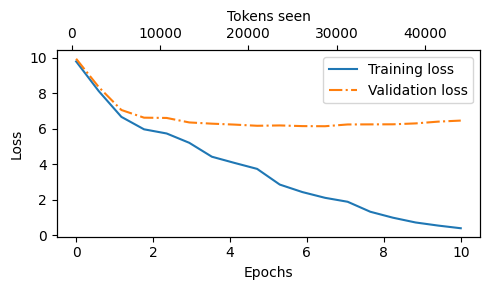

In [28]:
# =====================================================
# 绘制训练与验证损失随训练轮数变化图
# =====================================================
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator  # 用于控制坐标轴刻度

def plot_losses(epochs_seen, tokens_seen, train_losses, val_losses):
    """
    绘制训练损失和验证损失随训练轮数变化的图，并在上方添加“tokens seen”坐标轴。

    参数：
    - epochs_seen: 当前训练轮数对应的浮点序列（Tensor 或列表）
    - tokens_seen: 累计训练 token 数量列表
    - train_losses: 训练损失列表
    - val_losses: 验证损失列表
    """
    # 创建一个画布，大小为 (5 x 3) 英寸
    fig, ax1 = plt.subplots(figsize=(5, 3))

    # -----------------------------
    # 绘制训练和验证损失随 epochs 的曲线
    # -----------------------------
    ax1.plot(epochs_seen, train_losses, label="Training loss")        # 训练损失曲线
    ax1.plot(epochs_seen, val_losses, linestyle="-.", label="Validation loss")  # 验证损失曲线
    ax1.set_xlabel("Epochs")  # x 轴标签
    ax1.set_ylabel("Loss")    # y 轴标签
    ax1.legend(loc="upper right")  # 显示图例在右上角
    ax1.xaxis.set_major_locator(MaxNLocator(integer=True))  # x 轴只显示整数刻度

    # -----------------------------
    # 创建第二个 x 轴用于展示“Tokens seen”
    # -----------------------------
    ax2 = ax1.twiny()  # 创建共享 y 轴的上方 x 轴
    ax2.plot(tokens_seen, train_losses, alpha=0)  # 绘制透明曲线，仅用于对齐刻度
    ax2.set_xlabel("Tokens seen")  # 上方 x 轴标签

    # -----------------------------
    # 调整布局，避免标签和图像重叠
    # -----------------------------
    fig.tight_layout()

    # -----------------------------
    # 保存绘图为 PDF 文件
    # -----------------------------
    plt.savefig("loss-plot.pdf")

    # -----------------------------
    # 显示图形
    # -----------------------------
    plt.show()


# -----------------------------
# 将训练轮数序列从 0 到总轮数 num_epochs 等间隔生成，与 train_losses 长度一致
# -----------------------------
epochs_tensor = torch.linspace(0, num_epochs, len(train_losses))

# -----------------------------
# 调用函数绘制损失曲线
# -----------------------------
plot_losses(epochs_tensor, tokens_seen, train_losses, val_losses)


- 从上面的结果可以看到，模型一开始生成的是难以理解的词串，而到训练末期，它能够生成语法上大致正确的句子。  
- 然而，根据训练集和验证集的损失情况，可以看出模型开始出现过拟合。  
- 如果检查模型在训练末期生成的几段文本，会发现它们与训练集内容完全一致——模型只是记住了训练数据。  
- 后面我们将介绍一些解码策略（decoding strategies），可以在一定程度上缓解这种记忆现象。  
- 注意，这里的过拟合是因为我们使用的训练集非常非常小，同时对其迭代次数很多：  
  - 这里的 LLM 训练主要是为了教学目的，我们主要想看到模型能够学习生成连贯文本。  
  - 与其在大量昂贵硬件上花费数周或数月训练这个模型，我们后面将直接加载预训练权重。


<img src="https://sebastianraschka.com/images/LLMs-from-scratch-images/ch05_compressed/13.webp" width=350px>

**如果你有兴趣在这个训练函数中加入更高级的训练技巧，例如学习率预热（learning rate warmup）、余弦退火（cosine annealing）以及梯度裁剪（gradient clipping），请参阅 [附录 D](../../appendix-D/01_main-chapter-code)。**


**如果你希望使用更大的训练数据集并进行更长时间的训练，请参阅 [../03_bonus_pretraining_on_gutenberg](../03_bonus_pretraining_on_gutenberg)。**


## 5.3 解码策略以控制随机性


- 对于像我们上面训练的这个较小的 GPT 模型来说，推理（inference）成本相对较低，因此即使你之前使用 GPU 训练，也不必使用 GPU 进行推理。  
- 使用我们在前面简单训练函数中使用的 `generate_text_simple` 函数（来自上一章），我们可以一次生成一个单词（或 token）的新文本。  
- 如第 5.1.2 节所述，下一个生成的 token 是词汇表中概率分数最高的 token。


In [27]:
# =====================================================
# 使用 CPU 进行推理（inference），因为模型较小，推理开销低
# 并确保读者在本书后续章节中得到一致的结果
# =====================================================
inference_device = torch.device("cpu")  # 指定设备为 CPU

# 将模型移动到 CPU 上
model.to(inference_device)

# 设置模型为评估模式（禁用 dropout 等训练特定行为）
model.eval()

# 初始化 GPT-2 分词器
tokenizer = tiktoken.get_encoding("gpt2")

# -----------------------------
# 调用简单文本生成函数 generate_text_simple
# -----------------------------
token_ids = generate_text_simple(
    model=model,
    idx=text_to_token_ids("Every effort moves you", tokenizer).to(inference_device),  
    # 输入上下文序列 "Every effort moves you"，先编码成 token ID，再移动到 CPU
    max_new_tokens=25,       # 新生成 token 的最大数量
    context_size=GPT_CONFIG_124M["context_length"]  
    # 上下文窗口长度，确保模型仅使用最后 context_size 个 token 进行预测
)

# -----------------------------
# 将生成的 token IDs 转回可读文本
# -----------------------------
print("Output text:\n", token_ids_to_text(token_ids, tokenizer))


Output text:
 Every effort moves you know," was one of the axioms he laid down across the Sevres and silver of an exquisitely appointed lun


- 即使我们多次执行上面的 `generate_text_simple` 函数，LLM 生成的输出仍然会完全相同。  
- 现在我们引入两个概念，即所谓的解码策略（decoding strategies），用于改进 `generate_text_simple` 函数：**温度缩放（temperature scaling）** 和 **Top-k 采样（top-k sampling）**。  
- 这些策略可以让模型控制生成文本的随机性和多样性。


### 5.3.1 温度缩放（Temperature Scaling）


- 之前，我们总是使用 `torch.argmax` 选择概率最高的 token 作为下一个 token。  
- 为了增加多样性，我们可以使用 `torch.multinomial(probs, num_samples=1)` 从概率分布中采样下一个 token。  
- 在这里，每个索引被选中的概率与输入张量中对应的概率值成正比。


- 下面是一个关于“生成下一个 token”的小回顾，这里为了说明原理，我们假设词汇表（vocabulary）非常小：


In [28]:
# =====================================================
# 定义词汇表（vocab）和其反向映射（inverse_vocab）
# =====================================================
vocab = { 
    "closer": 0,
    "every": 1, 
    "effort": 2, 
    "forward": 3,
    "inches": 4,
    "moves": 5, 
    "pizza": 6,
    "toward": 7,
    "you": 8,
} 

# 生成反向字典：从 token_id -> token 字符串
inverse_vocab = {v: k for k, v in vocab.items()}

# =====================================================
# 假设输入文本为 "every effort moves you"
# 模型返回下一个 token 的 logits（未归一化得分）
# =====================================================
next_token_logits = torch.tensor(
    [4.51, 0.89, -1.90, 6.75, 1.63, -1.62, -1.89, 6.28, 1.79]
)
# Shape: (vocab_size,) = (9,)

# =====================================================
# 将 logits 转换为概率分布
# softmax 将 logits 归一化为总和为 1 的概率
# =====================================================
probas = torch.softmax(next_token_logits, dim=0)
# probas[i] 表示生成第 i 个 token 的概率

# =====================================================
# 选取概率最大的 token 作为下一个生成 token（贪心策略）
# =====================================================
next_token_id = torch.argmax(probas).item()
# torch.argmax 返回最大概率的索引
# .item() 将 0-d tensor 转为 Python int

# =====================================================
# 根据反向字典查找对应的 token
# =====================================================
print(inverse_vocab[next_token_id])
# 输出下一个生成的 token


forward


In [29]:
# =====================================================
# 固定随机种子，保证采样结果可复现
# =====================================================
torch.manual_seed(123)

# =====================================================
# 使用多项式采样 (multinomial) 从概率分布中抽取一个 token
# probas: 各 token 的概率分布
# num_samples=1: 抽取 1 个 token
# 返回的是 tensor，需要 .item() 转为 Python int
# =====================================================
next_token_id = torch.multinomial(probas, num_samples=1).item()

# =====================================================
# 根据反向字典查找对应的 token
# =====================================================
print(inverse_vocab[next_token_id])
# 输出根据概率采样得到的下一个 token


forward


- 与其使用 `torch.argmax` 来确定概率最高的 token，我们可以使用 `torch.multinomial(probas, num_samples=1)`，从 softmax 概率分布中**按概率进行采样**，以此决定下一个最可能的 token。  
- 为了演示这个原理，我们来看看当我们使用原始的 softmax 概率分布重复采样 1,000 次时会发生什么：


In [31]:
def print_sampled_tokens(probas):
    """
    演示概率采样（Multinomial Sampling）效果：
    对给定的 token 概率分布进行多次采样，并统计每个 token 被选中的次数。
    
    参数：
    - probas: torch.Tensor，形状 [vocab_size]
        表示每个 token 的概率（一般来自 softmax 输出），
        所有元素之和应为 1。
    """
    
    # ------------------------------
    # 固定随机种子以保证可复现
    # ------------------------------
    # 这里使用 123 作为随机种子
    # 这样每次运行都会得到相同的采样序列，便于教学演示
    torch.manual_seed(123)
    
    # ------------------------------
    # 多次从概率分布中采样 token
    # ------------------------------
    # 使用列表生成式进行 1000 次采样
    # torch.multinomial(input, num_samples=1)
    # - input: 概率分布 tensor，长度为 vocab_size
    # - num_samples: 每次采样多少个元素，这里为 1，即每次只选一个 token
    # - 返回值: tensor，长度为 num_samples，每个元素是对应 token 的索引
    # .item() 将 tensor 转换为 Python 整数
    sample = [
        torch.multinomial(probas, num_samples=1).item()  # 采样一个 token id
        for i in range(1_000)                            # 重复采样 1000 次
    ]
    
    # ------------------------------
    # 统计每个 token 被采样的次数
    # ------------------------------
    # torch.bincount(input, minlength)
    # - input: 一个包含非负整数的 1D tensor
    # - minlength: 返回的计数 tensor 的长度（保证包含 vocab_size 个 token）
    # 返回值: 长度为 minlength 的 tensor，tensor[i] 表示 token i 出现的次数
    sampled_ids = torch.bincount(torch.tensor(sample), minlength=len(probas))
    
    # ------------------------------
    # 打印每个 token 的采样次数
    # ------------------------------
    # enumerate: 遍历 sampled_ids，i 是 token 索引，freq 是出现次数
    # inverse_vocab[i] 根据 token id 得到对应文本
    for i, freq in enumerate(sampled_ids):
        print(f"{freq} x {inverse_vocab[i]}")  # 打印格式：出现次数 x token
    
# ------------------------------
# 调用函数示例
# ------------------------------
print_sampled_tokens(probas)


73 x closer
0 x every
0 x effort
582 x forward
2 x inches
0 x moves
0 x pizza
343 x toward
0 x you


- 我们可以通过一个称为温度缩放（temperature scaling）的概念来控制分布和选择过程。  
- “温度缩放”其实就是一个术语，指的是将 logits 除以一个大于 0 的数。  
- 温度大于 1 时，经过 softmax 后，token 的概率分布会更加均匀。  
- 温度小于 1 时，经过 softmax 后，分布会更加自信（更尖锐或更集中）。


- 请注意，经过 dropout 后的输出可能会因操作系统不同而有所差异；你可以在 [PyTorch 问题追踪](https://github.com/pytorch/pytorch/issues/121595) 中了解更多关于这种不一致性的内容。


In [32]:
# -----------------------------
# 定义带温度系数的 softmax 函数
# -----------------------------
def softmax_with_temperature(logits, temperature):
    """
    logits: 1D 张量，表示模型输出的各个 token 的未归一化分数（logits）
    temperature: 温度系数，控制采样分布的“平滑度”或“尖锐度”
                 - temperature < 1 → 分布更尖锐，概率集中在最大值附近
                 - temperature > 1 → 分布更平坦，更随机
    返回值: softmax 后的概率分布张量，和 logits 维度一致
    """
    # 将 logits 按温度缩放
    # 注意：temperature 为 1 时，不改变 logits；temperature < 1 会放大 logits 差异
    scaled_logits = logits / temperature

    # 对缩放后的 logits 计算 softmax
    # dim=0 表示对整个一维张量计算 softmax
    return torch.softmax(scaled_logits, dim=0)


# -----------------------------
# 定义不同的温度值
# -----------------------------
temperatures = [1, 0.1, 5]  # 三种情况：
# 1: 原始 logits
# 0.1: 极低温度 → 高置信度，概率更集中于最大 logits
# 5: 高温度 → 低置信度，概率更均匀，更随机


# -----------------------------
# 对每个温度值计算缩放后的概率
# -----------------------------
scaled_probas = [
    softmax_with_temperature(next_token_logits, T)  # 调用上面定义的函数
    for T in temperatures
]

# scaled_probas 是一个列表，长度 = len(temperatures)
# 每个元素都是与 next_token_logits 形状相同的一维概率张量
# 你可以用下面方式查看结果：
for T, prob in zip(temperatures, scaled_probas):
    print(f"Temperature {T}: {prob}")


Temperature 1: tensor([6.0907e-02, 1.6313e-03, 1.0019e-04, 5.7212e-01, 3.4190e-03, 1.3257e-04,
        1.0120e-04, 3.5758e-01, 4.0122e-03])
Temperature 0.1: tensor([1.8530e-10, 3.5189e-26, 2.6890e-38, 9.9099e-01, 5.7569e-23, 4.4220e-37,
        2.9718e-38, 9.0133e-03, 2.8514e-22])
Temperature 5: tensor([0.1546, 0.0750, 0.0429, 0.2421, 0.0869, 0.0454, 0.0430, 0.2203, 0.0898])


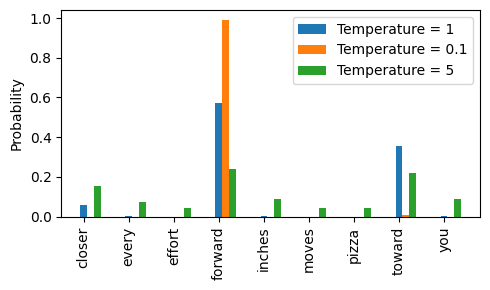

In [34]:
# -----------------------------
# 绘制不同温度下的概率分布柱状图
# -----------------------------

# x 轴的刻度：每个 token 对应一个整数位置
# torch.arange(len(vocab)) 会生成 [0, 1, 2, ..., len(vocab)-1]
x = torch.arange(len(vocab))

# 每个柱子的宽度
bar_width = 0.15

# 创建图形和坐标轴
# figsize=(5,3) 表示图形宽 5 英寸，高 3 英寸
fig, ax = plt.subplots(figsize=(5, 3))

# 循环绘制不同温度下的柱状图
for i, T in enumerate(temperatures):
    # x + i*bar_width：为了不同温度的柱子不重叠，横向偏移 i*bar_width
    # scaled_probas[i]：该温度下每个 token 的概率
    # bar_width：柱子宽度
    # label=f'Temperature = {T}'：图例标签
    rects = ax.bar(
        x + i * bar_width, 
        scaled_probas[i], 
        bar_width, 
        label=f'Temperature = {T}'
    )

# 设置 y 轴标签
ax.set_ylabel('Probability')

# 设置 x 轴刻度位置
ax.set_xticks(x)

# 设置 x 轴刻度标签
# vocab.keys() 是 token 名称
# rotation=90 表示旋转 90 度，使标签竖直显示，避免重叠
ax.set_xticklabels(vocab.keys(), rotation=90)

# 显示图例
ax.legend()

# 调整布局，避免标签或图例被裁剪
plt.tight_layout()

# 保存图形为 PDF
plt.savefig("temperature-plot.pdf")

# 显示图形
plt.show()


- 我们可以看到，通过温度参数 0.1 进行重新缩放（rescaling）会得到一个更尖锐的分布，接近于 `torch.argmax`，这样最可能的单词几乎总是被选中：


In [33]:
# 调用我们之前定义的函数 print_sampled_tokens
# 作用：根据概率向量采样 1000 次 token，并统计每个 token 被采样的次数
# scaled_probas[1] 是温度 T=0.1 对应的概率分布
print_sampled_tokens(scaled_probas[1])


0 x closer
0 x every
0 x effort
985 x forward
0 x inches
0 x moves
0 x pizza
15 x toward
0 x you


- 通过温度参数 5 进行重新缩放后的概率分布更接近均匀分布：


In [34]:
print_sampled_tokens(scaled_probas[2])

165 x closer
75 x every
42 x effort
239 x forward
71 x inches
46 x moves
32 x pizza
227 x toward
103 x you


- 假设 LLM 的输入为 "every effort moves you"，使用上述采样方法有时会生成无意义的文本，例如 "every effort moves you pizza"，出现概率为 3.2%（在 1,000 次中出现 32 次）


### 5.3.2 Top-k 采样


- 为了能够使用更高的温度（temperature）来增加输出的多样性，并降低生成无意义句子的概率，我们可以将采样范围限制在概率最高的前 k 个 token（top-k tokens）：


<img src="https://sebastianraschka.com/images/LLMs-from-scratch-images/ch05_compressed/15.webp" width=500px>

- （请注意，为了减少视觉混乱，图中的数字仅保留了小数点后两位。Softmax 行中的数值总和应为 1.0。）


- 在代码中，我们可以如下实现 Top-k 采样：


In [35]:
# 设置 top-k 采样参数
top_k = 3  # 我们只考虑概率最大的前 3 个 token

# torch.topk 函数：返回张量中前 k 个最大值及其索引
# 参数解释：
#   next_token_logits : 输入张量（本例中是 logits，长度 = 词汇表大小）
#   top_k             : 返回前 k 个元素
# 返回：
#   top_logits : 前 k 个最大值（tensor）
#   top_pos    : 对应的索引（tensor），即 token id
top_logits, top_pos = torch.topk(next_token_logits, top_k)

# 打印前 k 个最大 logits 的值
print("Top logits:", top_logits)

# 打印前 k 个最大 logits 对应的 token id
print("Top positions:", top_pos)


Top logits: tensor([6.7500, 6.2800, 4.5100])
Top positions: tensor([3, 7, 0])


In [36]:
# 目标：实现 Top-K 采样的 logits 屏蔽
# 将非 top-k 的 logits 设置为 -inf，从而在 softmax 时概率为 0

new_logits = torch.where(
    condition=next_token_logits < top_logits[-1],  # 条件：哪些 logits 小于 top-k 中最小的那个
    input=torch.tensor(float("-inf")),            # 满足条件的元素替换为 -inf
    other=next_token_logits                        # 不满足条件的元素保持原值
)

# 输出处理后的 logits
print(new_logits)


tensor([4.5100,   -inf,   -inf, 6.7500,   -inf,   -inf,   -inf, 6.2800,   -inf])


> 注意：  
>
> 上一个代码单元格的另一种稍微高效的实现如下：
>
> ```python
> new_logits = torch.full_like( # 创建一个所有元素为 -inf 的张量
>    next_token_logits, -torch.inf
>)   
> new_logits[top_pos] = next_token_logits[top_pos] # 将 top k 的值复制到 -inf 张量中
> ```
> <br>
> 更多细节请参见 https://github.com/rasbt/LLMs-from-scratch/discussions/326


In [37]:
# 将处理后的 logits 转换为概率分布
topk_probas = torch.softmax(new_logits, dim=0)

print(topk_probas)

tensor([0.0615, 0.0000, 0.0000, 0.5775, 0.0000, 0.0000, 0.0000, 0.3610, 0.0000])


### 5.3.3 修改文本生成函数


- 前面两个小节介绍了温度采样（temperature sampling）和 Top-k 采样（top-k sampling）。  
- 现在让我们使用这两个概念来修改第 4 章的 `generate_text_simple` 函数，创建一个新的 `generate` 函数：


In [38]:
def generate(model, idx, max_new_tokens, context_size, temperature=0.0, top_k=None, eos_id=None):
    """
    基于当前上下文 idx 生成新的 token 序列

    参数：
    - model: 已训练的 GPT 模型
    - idx: 当前上下文 token 索引张量，形状 [batch_size, n_tokens]
    - max_new_tokens: 最多生成的新 token 个数
    - context_size: 模型最大上下文长度
    - temperature: 温度系数，控制采样分布的平滑度（0 表示贪心）
    - top_k: 如果不为 None，则进行 top-k 采样
    - eos_id: 如果不为 None，遇到该 token 将提前停止生成
    """

    # 生成循环，每次生成一个新的 token
    for _ in range(max_new_tokens):
        # -------------------------
        # 截断上下文以适应模型最大 context_size
        # idx_cond 形状: [batch_size, min(current_seq_len, context_size)]
        # -------------------------
        idx_cond = idx[:, -context_size:]

        # -------------------------
        # 前向推理，禁用梯度
        # -------------------------
        with torch.no_grad():
            logits = model(idx_cond)  # 输出形状: [batch_size, seq_len, vocab_size]

        # 只关注最后一个 token 的 logits，形状: [batch_size, vocab_size]
        logits = logits[:, -1, :]

        # -------------------------
        # top-k 采样逻辑
        # -------------------------
        if top_k is not None:
            # 获取每行前 top_k 个 logits 及其索引
            top_logits, _ = torch.topk(logits, top_k)  # top_logits 形状: [batch_size, top_k]

            # 最小的 top-k 值（第 k 大）
            min_val = top_logits[:, -1].unsqueeze(-1)  # 形状: [batch_size, 1]，用于广播

            # 将小于 top-k 最小值的 logits 设置为 -inf
            logits = torch.where(
                logits < min_val,
                torch.tensor(float("-inf")).to(logits.device),  # 置为 -inf
                logits
            )

        # -------------------------
        # 温度缩放逻辑
        # -------------------------
        if temperature > 0.0:
            logits = logits / temperature  # logits 除以温度，T>1 平滑分布，T<1 使分布更尖锐

            # 数值稳定性优化（特别是 MPS 或 GPU 上）
            logits = logits - logits.max(dim=-1, keepdim=True).values  # 减去行最大值

            # softmax 转换为概率分布
            probs = torch.softmax(logits, dim=-1)  # [batch_size, vocab_size]

            # 按概率采样下一个 token
            idx_next = torch.multinomial(probs, num_samples=1)  # [batch_size, 1]

        # -------------------------
        # temperature=0 时使用贪心策略
        # -------------------------
        else:
            idx_next = torch.argmax(logits, dim=-1, keepdim=True)  # [batch_size, 1]

        # -------------------------
        # 遇到 eos_id 时提前停止生成
        # -------------------------
        if eos_id is not None and (idx_next == eos_id).all():
            break

        # -------------------------
        # 将生成的 token 添加到当前序列
        # idx 形状: [batch_size, n_tokens+1]
        # -------------------------
        idx = torch.cat((idx, idx_next), dim=1)

    return idx


In [39]:
# -------------------------
# 设置随机种子，保证采样可复现
# -------------------------
torch.manual_seed(123)

# -------------------------
# 调用自定义的 generate 函数生成新 token 序列
# -------------------------
token_ids = generate(
    model=model,  # 已训练的 GPT 模型
    idx=text_to_token_ids("Every effort moves you", tokenizer).to(inference_device),  
    # 初始上下文，将文本编码为 token，并移动到指定设备（CPU/GPU）

    max_new_tokens=15,  
    # 最多生成 15 个新的 token

    context_size=GPT_CONFIG_124M["context_length"],  
    # 模型的最大上下文长度，用于截断输入序列

    top_k=25,  
    # 仅从概率最高的前 25 个 token 中采样，控制生成多样性

    temperature=1.4  
    # 温度系数 T>1 会让分布更平滑，提高随机性
    # T<1 会让分布更尖锐，更倾向选择高概率 token
)

# -------------------------
# 将生成的 token 序列解码为可读文本
# -------------------------
print("Output text:\n", token_ids_to_text(token_ids, tokenizer))


Output text:
 Every effort moves you stand to work on surprise, a one of us had gone with random-


## 5.4 在 PyTorch 中加载和保存模型权重


- 训练 LLM 的计算成本很高，因此能够保存和加载 LLM 权重非常重要。

<img src="https://sebastianraschka.com/images/LLMs-from-scratch-images/ch05_compressed/16.webp" width=400px>


- 在 PyTorch 中，推荐的做法是保存模型权重，即所谓的 `state_dict`，方法是对模型的 `.state_dict()` 使用 `torch.save` 函数：


In [40]:
# -------------------------
# 保存模型参数到本地文件
# -------------------------
torch.save(
    model.state_dict(),  # 获取模型的所有可训练参数（权重和偏置）
    "model.pth"           # 保存文件名，可自定义，如 "gpt_model.pth"
)


- 然后，我们可以将模型权重加载到一个新的 `GPTModel` 实例中，如下所示：


In [42]:
# -------------------------
# 1️ 重新创建模型结构
# -------------------------
model = GPTModel(GPT_CONFIG_124M)  
# 这里必须先用和训练时完全相同的配置创建模型对象
# GPT_CONFIG_124M 包含 vocab_size、emb_dim、n_layers、n_heads 等参数

# -------------------------
# 2️ 选择设备
# -------------------------
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")  
# 优先使用 GPU，如果没有 GPU 则使用 CPU

# -------------------------
# 3️ 加载模型权重
# -------------------------
model.load_state_dict(
    torch.load(
        "model.pth",          # 保存的模型权重文件
        map_location=device    # 将权重映射到当前设备（CPU 或 GPU）
    ),
#    weights_only=True         # 只加载权重，不改变模型结构
)

# -------------------------
# 4️ 切换到评估模式
# -------------------------
model.eval()  
# 禁用 Dropout / BatchNorm 等训练特定行为
# 用于推理 / 生成文本


GPTModel(
  (tok_emb): Embedding(50257, 768)
  (pos_emb): Embedding(256, 768)
  (drop_emb): Dropout(p=0.1, inplace=False)
  (trf_blocks): Sequential(
    (0): TransformerBlock(
      (att): MultiHeadAttention(
        (W_query): Linear(in_features=768, out_features=768, bias=False)
        (W_key): Linear(in_features=768, out_features=768, bias=False)
        (W_value): Linear(in_features=768, out_features=768, bias=False)
        (out_proj): Linear(in_features=768, out_features=768, bias=True)
        (dropout): Dropout(p=0.1, inplace=False)
      )
      (ff): FeedForward(
        (layers): Sequential(
          (0): Linear(in_features=768, out_features=3072, bias=True)
          (1): GELU()
          (2): Linear(in_features=3072, out_features=768, bias=True)
        )
      )
      (norm1): LayerNorm()
      (norm2): LayerNorm()
      (drop_shortcut): Dropout(p=0.1, inplace=False)
    )
    (1): TransformerBlock(
      (att): MultiHeadAttention(
        (W_query): Linear(in_features

- 训练 LLM 时，通常会使用自适应优化器（adaptive optimizers），如 Adam 或 AdamW，而不是普通的 SGD。  
- 这些自适应优化器会为每个模型权重存储额外的参数，因此如果我们计划后续继续预训练（pretraining），保存这些参数也是有意义的：


In [43]:
import torch

# -------------------------------------------------------------
# 保存模型权重和优化器状态
# -------------------------------------------------------------

torch.save({
    # 保存模型的参数字典
    "model_state_dict": model.state_dict(),  
    
    # 保存优化器的参数字典（例如 AdamW 的动量、步数等状态）
    "optimizer_state_dict": optimizer.state_dict(),  
}, 
"model_and_optimizer.pth")  # 保存为文件名 model_and_optimizer.pth


In [45]:
# checkpoint = torch.load("model_and_optimizer.pth", weights_only=True)

# model = GPTModel(GPT_CONFIG_124M)
# model.load_state_dict(checkpoint["model_state_dict"])

# optimizer = torch.optim.AdamW(model.parameters(), lr=0.0005, weight_decay=0.1)
# optimizer.load_state_dict(checkpoint["optimizer_state_dict"])
# model.train();

In [44]:
# -------------------------
# 1️ 加载 checkpoint 文件
# -------------------------
# checkpoint 文件包含模型权重和优化器状态字典
checkpoint = torch.load("model_and_optimizer.pth", map_location="cpu")
# map_location="cpu" 可以确保在 CPU 上加载，如果有 GPU 可以改为 map_location=device

# -------------------------
# 2️ 初始化模型
# -------------------------
model = GPTModel(GPT_CONFIG_124M)

# -------------------------
# 3️ 加载模型权重
# -------------------------
model.load_state_dict(checkpoint["model_state_dict"])  
# 注意：这里不需要 weights_only=True，PyTorch 并不支持该参数

# -------------------------
# 4️ 初始化优化器
# -------------------------
optimizer = torch.optim.AdamW(model.parameters(), lr=0.0005, weight_decay=0.1)

# -------------------------
# 5️ 加载优化器状态
# -------------------------
optimizer.load_state_dict(checkpoint["optimizer_state_dict"])

# -------------------------
# 6️ 切换到训练模式
# -------------------------
model.train()  # 如果用于推理则用 model.eval()


GPTModel(
  (tok_emb): Embedding(50257, 768)
  (pos_emb): Embedding(256, 768)
  (drop_emb): Dropout(p=0.1, inplace=False)
  (trf_blocks): Sequential(
    (0): TransformerBlock(
      (att): MultiHeadAttention(
        (W_query): Linear(in_features=768, out_features=768, bias=False)
        (W_key): Linear(in_features=768, out_features=768, bias=False)
        (W_value): Linear(in_features=768, out_features=768, bias=False)
        (out_proj): Linear(in_features=768, out_features=768, bias=True)
        (dropout): Dropout(p=0.1, inplace=False)
      )
      (ff): FeedForward(
        (layers): Sequential(
          (0): Linear(in_features=768, out_features=3072, bias=True)
          (1): GELU()
          (2): Linear(in_features=3072, out_features=768, bias=True)
        )
      )
      (norm1): LayerNorm()
      (norm2): LayerNorm()
      (drop_shortcut): Dropout(p=0.1, inplace=False)
    )
    (1): TransformerBlock(
      (att): MultiHeadAttention(
        (W_query): Linear(in_features

## 5.5 从 OpenAI 加载预训练权重


- 之前，我们仅使用一个非常短的小故事书对一个小型 GPT-2 模型进行了训练，主要出于教学目的。  
- 感兴趣的读者也可以在 [../03_bonus_pretraining_on_gutenberg](../03_bonus_pretraining_on_gutenberg) 找到在完整 Project Gutenberg 书籍语料库上进行的更长时间的预训练示例。  
- 幸运的是，我们不必花费数万甚至数十万美元在大型预训练语料上训练模型，而可以直接加载 OpenAI 提供的预训练权重。


---

---


⚠️ **注意：在本节中，一些用户可能会遇到 TensorFlow 兼容性问题，尤其是在某些 Windows 系统上。这里使用 TensorFlow 仅用于加载原始的 OpenAI GPT-2 权重文件，然后将其转换为 PyTorch。  
如果你遇到与 TensorFlow 相关的问题，可以使用下面的替代代码，而不是本节余下的代码。  
该替代方案基于预先转换好的 PyTorch 权重，转换过程与前一节中描述的相同。详情请参阅笔记本：[../02_alternative_weight_loading/weight-loading-pytorch.ipynb](../02_alternative_weight_loading/weight-loading-pytorch.ipynb)。**


```python
file_name = "gpt2-small-124M.pth"
# file_name = "gpt2-medium-355M.pth"
# file_name = "gpt2-large-774M.pth"
# file_name = "gpt2-xl-1558M.pth"

url = f"https://huggingface.co/rasbt/gpt2-from-scratch-pytorch/resolve/main/{file_name}"

if not os.path.exists(file_name):
    urllib.request.urlretrieve(url, file_name)
    print(f"Downloaded to {file_name}")

gpt = GPTModel(BASE_CONFIG)
gpt.load_state_dict(torch.load(file_name, weights_only=True))
gpt.eval()

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
gpt.to(device);


torch.manual_seed(123)

token_ids = generate(
    model=gpt,
    idx=text_to_token_ids("Every effort moves you", tokenizer).to(device),
    max_new_tokens=25,
    context_size=NEW_CONFIG["context_length"],
    top_k=50,
    temperature=1.5
)

print("Output text:\n", token_ids_to_text(token_ids, tokenizer))
```

---

---

- 首先，一些样板代码用于从 OpenAI 下载文件并将权重加载到 Python 中。  
- 由于 OpenAI 使用了 [TensorFlow](https://www.tensorflow.org/)，我们需要安装并使用 TensorFlow 来加载权重；[tqdm](https://github.com/tqdm/tqdm) 是一个进度条库。  
- 取消注释并运行下一个单元格，以安装所需的库。


In [46]:
#pip install tensorflow tqdm

In [47]:
print("TensorFlow version:", version("tensorflow"))
print("tqdm version:", version("tqdm"))

TensorFlow version: 2.20.0
tqdm version: 4.67.1


In [48]:
# -------------------------
# 1️ 从本地模块导入函数
# -------------------------
# 相对导入 gpt_download.py 文件中的 download_and_load_gpt2 函数
# 假设 gpt_download.py 与当前 Notebook/脚本在同一目录
from gpt_download import download_and_load_gpt2

# -------------------------
# 2️ 可选的替代导入方式
# -------------------------
# 如果你安装了 llms-from-scratch 包，可以直接从包中导入
# 注意：包名可能随版本不同而不同，路径要根据实际安装情况修改
# from llms_from_scratch.ch05 import download_and_load_gpt2


---

**注意**

- 在极少数情况下，上面的代码单元可能会导致 `zsh: illegal hardware instruction python` 错误，这可能是由于你机器上的 TensorFlow 安装问题。  
- 有读者发现，在这种情况下，通过 `conda` 安装 TensorFlow 可以解决问题，如 [这里](https://github.com/rasbt/LLMs-from-scratch/discussions/273#discussioncomment-12367888) 所述。  
- 你可以在这个补充的 [Python 安装教程](https://github.com/rasbt/LLMs-from-scratch/tree/main/setup/01_optional-python-setup-preferences#option-2-using-conda) 中找到更多说明。

---

- 然后，我们可以按如下方式下载 1.24 亿参数模型的权重：


In [49]:
# 调用 download_and_load_gpt2 函数下载并加载 GPT-2 模型权重
# 并返回两个对象：模型配置（settings）和模型参数（params）
settings, params = download_and_load_gpt2(
    model_size="124M",   # 指定 GPT-2 模型大小，可选 "124M", "355M", "774M", "1558M"
    models_dir="gpt2"    # 指定本地存储预训练模型权重的目录，如果不存在则会自动创建
)

# -------------------------
# 返回值说明：
# -------------------------
# settings: 包含模型架构信息（如层数、头数、embedding 维度等）的字典
# params:   一个字典，包含所有下载的模型权重（如 token embedding、attention 权重等）


checkpoint: 100%|██████████████████████████████████████████████████████████████████| 77.0/77.0 [00:00<00:00, 39.7kiB/s]
encoder.json: 100%|██████████████████████████████████████████████████████████████| 1.04M/1.04M [00:00<00:00, 1.25MiB/s]
hparams.json: 100%|████████████████████████████████████████████████████████████████| 90.0/90.0 [00:00<00:00, 51.0kiB/s]
model.ckpt.data-00000-of-00001: 100%|██████████████████████████████████████████████| 498M/498M [03:36<00:00, 2.30MiB/s]
model.ckpt.index: 100%|██████████████████████████████████████████████████████████| 5.21k/5.21k [00:00<00:00, 5.24MiB/s]
model.ckpt.meta: 100%|██████████████████████████████████████████████████████████████| 471k/471k [00:00<00:00, 810kiB/s]
vocab.bpe: 100%|████████████████████████████████████████████████████████████████████| 456k/456k [00:00<00:00, 766kiB/s]


In [51]:
# 打印 GPT-2 模型的配置信息
# settings 是一个字典，包含模型的架构参数和超参数
print("Settings:", settings)

Settings: {'n_vocab': 50257, 'n_ctx': 1024, 'n_embd': 768, 'n_head': 12, 'n_layer': 12}


In [52]:
# 打印从 GPT-2 下载的权重字典的键
# params 是一个字典（Python dict），存储模型的所有参数张量
# keys() 方法返回字典中所有键名，方便了解模型有哪些参数
print("Parameter dictionary keys:", params.keys())

Parameter dictionary keys: dict_keys(['blocks', 'b', 'g', 'wpe', 'wte'])


In [53]:
# -----------------------------
# 查看 GPT-2 模型的 token embedding 权重
# -----------------------------

# 打印 "wte" 对应的张量
# 'wte' 是 "word token embedding" 的简称
# 即词表中每个 token 对应的嵌入向量 (embedding vector)
print(params["wte"])

# 打印 token embedding 张量的形状（维度）
# 通常形状为 [vocab_size, emb_dim]
# vocab_size：词表大小，即有多少不同的 token
# emb_dim：嵌入向量的维度（GPT-2 小模型 124M 为 768）
print("Token embedding weight tensor dimensions:", params["wte"].shape)

[[-0.11010301 -0.03926672  0.03310751 ... -0.1363697   0.01506208
   0.04531523]
 [ 0.04034033 -0.04861503  0.04624869 ...  0.08605453  0.00253983
   0.04318958]
 [-0.12746179  0.04793796  0.18410145 ...  0.08991534 -0.12972379
  -0.08785918]
 ...
 [-0.04453601 -0.05483596  0.01225674 ...  0.10435229  0.09783269
  -0.06952604]
 [ 0.1860082   0.01665728  0.04611587 ... -0.09625227  0.07847701
  -0.02245961]
 [ 0.05135201 -0.02768905  0.0499369  ...  0.00704835  0.15519823
   0.12067825]]
Token embedding weight tensor dimensions: (50257, 768)


- 另外，`model_size` 参数还支持 "355M"、"774M" 和 "1558M"。  
- 不同大小模型的差异总结如下图：


<img src="https://sebastianraschka.com/images/LLMs-from-scratch-images/ch05_compressed/17.webp" width=500px>

- 上面，我们已经将 1.24 亿参数的 GPT-2 模型权重加载到 Python 中，但我们仍需要将它们转移到我们的 `GPTModel` 实例中。  
- 首先，我们初始化一个新的 `GPTModel` 实例。  
- 注意，原始 GPT 模型在多头注意力模块中初始化查询（query）、键（key）和值（value）矩阵的线性层时使用了偏置向量（bias vectors），这并非必须或推荐；但为了能够正确加载权重，我们在实现中也必须将 `qkv_bias` 设置为 `True`。  
- 我们还使用了原始 GPT-2 模型采用的 `1024` token 上下文长度（context length）。


In [54]:
# -----------------------------
# 1️ 定义不同 GPT-2 模型的基础配置字典
# -----------------------------
# 每个 key 是模型名称，value 是一个字典，包含该模型的核心参数：
# - emb_dim: 词向量维度
# - n_layers: Transformer 层数
# - n_heads: 多头注意力头数
model_configs = {
    "gpt2-small (124M)": {"emb_dim": 768, "n_layers": 12, "n_heads": 12},
    "gpt2-medium (355M)": {"emb_dim": 1024, "n_layers": 24, "n_heads": 16},
    "gpt2-large (774M)": {"emb_dim": 1280, "n_layers": 36, "n_heads": 20},
    "gpt2-xl (1558M)": {"emb_dim": 1600, "n_layers": 48, "n_heads": 25},
}

# -----------------------------
# 2️ 选择要使用的模型名称
# -----------------------------
model_name = "gpt2-small (124M)"  # 示例：使用最小的 124M GPT-2

# -----------------------------
# 3️ 复制基础配置并更新为选定模型的参数
# -----------------------------
# GPT_CONFIG_124M 是之前定义的基础配置字典
# 使用 copy() 避免修改原始字典
NEW_CONFIG = GPT_CONFIG_124M.copy()

# 更新为指定模型的核心参数（词向量维度、层数、多头数）
NEW_CONFIG.update(model_configs[model_name])

# 进一步更新上下文长度和 QKV bias（可选）
NEW_CONFIG.update({"context_length": 1024, "qkv_bias": True})

# -----------------------------
# 4️ 初始化 GPT 模型
# -----------------------------
# 使用更新后的配置创建 GPTModel 实例
gpt = GPTModel(NEW_CONFIG)

# -----------------------------
# 5️ 切换模型到评估模式
# -----------------------------
# eval() 禁用 dropout 和其他训练时特性，用于推理
gpt.eval()


GPTModel(
  (tok_emb): Embedding(50257, 768)
  (pos_emb): Embedding(1024, 768)
  (drop_emb): Dropout(p=0.1, inplace=False)
  (trf_blocks): Sequential(
    (0): TransformerBlock(
      (att): MultiHeadAttention(
        (W_query): Linear(in_features=768, out_features=768, bias=True)
        (W_key): Linear(in_features=768, out_features=768, bias=True)
        (W_value): Linear(in_features=768, out_features=768, bias=True)
        (out_proj): Linear(in_features=768, out_features=768, bias=True)
        (dropout): Dropout(p=0.1, inplace=False)
      )
      (ff): FeedForward(
        (layers): Sequential(
          (0): Linear(in_features=768, out_features=3072, bias=True)
          (1): GELU()
          (2): Linear(in_features=3072, out_features=768, bias=True)
        )
      )
      (norm1): LayerNorm()
      (norm2): LayerNorm()
      (drop_shortcut): Dropout(p=0.1, inplace=False)
    )
    (1): TransformerBlock(
      (att): MultiHeadAttention(
        (W_query): Linear(in_features=7

- 接下来的任务是将 OpenAI 权重分配给我们 `GPTModel` 实例中的对应权重张量


In [55]:
def assign(left, right):
    """
    将右侧张量的值赋给左侧张量，并返回一个 nn.Parameter 类型的张量。
    主要用于确保在模型权重初始化或更新时，左右张量形状匹配。

    参数：
    - left: 原始张量（通常是模型的权重张量）
    - right: 新的张量（通常来自外部权重或预训练权重）

    返回：
    - 一个 torch.nn.Parameter 类型的张量，值与 right 相同
    """
    
    # -----------------------------
    # 1️ 检查左右张量的形状是否一致
    # -----------------------------
    # 如果形状不匹配，抛出错误，避免赋值错误
    if left.shape != right.shape:
        raise ValueError(f"Shape mismatch. Left: {left.shape}, Right: {right.shape}")
    
    # -----------------------------
    # 2️ 创建一个新的 nn.Parameter
    # -----------------------------
    # torch.tensor(right) 将 right 转换为新的张量
    # nn.Parameter 会将其注册为模型的可训练参数
    return torch.nn.Parameter(torch.tensor(right))


In [57]:
import numpy as np

def load_weights_into_gpt(gpt, params):
    """
    将下载的 GPT-2 预训练权重加载到自定义 GPT 模型中。
    
    参数：
    - gpt: 自定义 GPTModel 实例
    - params: 预训练模型权重字典，从 download_and_load_gpt2() 获取
    
    说明：
    GPT-2 模型权重结构：
    - 'wte' : token embedding 权重
    - 'wpe' : position embedding 权重
    - 'blocks' : 包含每个 Transformer Block 的字典列表
    - 'g', 'b' : 最终 LayerNorm 的 scale 和 shift
    """
    
    # -----------------------------
    # 1️ 位置嵌入层 (Positional Embedding)
    # -----------------------------
    # GPT-2 使用固定长度 context 的位置编码，存储在 'wpe' 中
    # gpt.pos_emb.weight 是自定义模型的位置嵌入层权重
    # assign() 会检查形状并转换为 nn.Parameter
    gpt.pos_emb.weight = assign(gpt.pos_emb.weight, params['wpe'])
    
    # -----------------------------
    # 2️ 词嵌入层 (Token Embedding)
    # -----------------------------
    # gpt.tok_emb.weight 是自定义模型的词嵌入层权重
    # 'wte' 来自 GPT-2 预训练模型
    gpt.tok_emb.weight = assign(gpt.tok_emb.weight, params['wte'])
    
    # -----------------------------
    # 3️ Transformer Block 权重
    # -----------------------------
    # GPT-2 每一层 Transformer block 的权重存储在 blocks 列表中
    for b in range(len(params["blocks"])):
        
        # -----------------------------
        # 3.1 拆分 Q/K/V 权重
        # -----------------------------
        # GPT-2 的注意力层使用一个线性层 c_attn 同时生成 Q/K/V
        # 权重 shape: (emb_dim, 3 * emb_dim)
        # np.split 按最后一维分为三个矩阵
        q_w, k_w, v_w = np.split(
            (params["blocks"][b]["attn"]["c_attn"])["w"], 3, axis=-1
        )
        
        # PyTorch 的 nn.Linear 权重 shape: (out_features, in_features)
        # 因此需要转置 q_w.T
        gpt.trf_blocks[b].att.W_query.weight = assign(
            gpt.trf_blocks[b].att.W_query.weight, q_w.T
        )
        gpt.trf_blocks[b].att.W_key.weight = assign(
            gpt.trf_blocks[b].att.W_key.weight, k_w.T
        )
        gpt.trf_blocks[b].att.W_value.weight = assign(
            gpt.trf_blocks[b].att.W_value.weight, v_w.T
        )
        
        # -----------------------------
        # 3.2 拆分 Q/K/V 偏置
        # -----------------------------
        # 偏置 shape: (3*emb_dim,)
        q_b, k_b, v_b = np.split(
            (params["blocks"][b]["attn"]["c_attn"])["b"], 3, axis=-1
        )
        gpt.trf_blocks[b].att.W_query.bias = assign(
            gpt.trf_blocks[b].att.W_query.bias, q_b
        )
        gpt.trf_blocks[b].att.W_key.bias = assign(
            gpt.trf_blocks[b].att.W_key.bias, k_b
        )
        gpt.trf_blocks[b].att.W_value.bias = assign(
            gpt.trf_blocks[b].att.W_value.bias, v_b
        )
        
        # -----------------------------
        # 3.3 注意力输出投影 (Output Projection)
        # -----------------------------
        # c_proj 是注意力输出投影矩阵
        # 转置原因同上
        gpt.trf_blocks[b].att.out_proj.weight = assign(
            gpt.trf_blocks[b].att.out_proj.weight,
            params["blocks"][b]["attn"]["c_proj"]["w"].T
        )
        gpt.trf_blocks[b].att.out_proj.bias = assign(
            gpt.trf_blocks[b].att.out_proj.bias,
            params["blocks"][b]["attn"]["c_proj"]["b"]
        )
        
        # -----------------------------
        # 3.4 前馈网络 (MLP)
        # -----------------------------
        # MLP 第一层 (c_fc)
        gpt.trf_blocks[b].ff.layers[0].weight = assign(
            gpt.trf_blocks[b].ff.layers[0].weight,
            params["blocks"][b]["mlp"]["c_fc"]["w"].T
        )
        gpt.trf_blocks[b].ff.layers[0].bias = assign(
            gpt.trf_blocks[b].ff.layers[0].bias,
            params["blocks"][b]["mlp"]["c_fc"]["b"]
        )
        # MLP 第二层 (c_proj)
        gpt.trf_blocks[b].ff.layers[2].weight = assign(
            gpt.trf_blocks[b].ff.layers[2].weight,
            params["blocks"][b]["mlp"]["c_proj"]["w"].T
        )
        gpt.trf_blocks[b].ff.layers[2].bias = assign(
            gpt.trf_blocks[b].ff.layers[2].bias,
            params["blocks"][b]["mlp"]["c_proj"]["b"]
        )
        
        # -----------------------------
        # 3.5 LayerNorm 权重
        # -----------------------------
        # norm1 对应注意力输出后的归一化
        gpt.trf_blocks[b].norm1.scale = assign(
            gpt.trf_blocks[b].norm1.scale,
            params["blocks"][b]["ln_1"]["g"]
        )
        gpt.trf_blocks[b].norm1.shift = assign(
            gpt.trf_blocks[b].norm1.shift,
            params["blocks"][b]["ln_1"]["b"]
        )
        # norm2 对应 MLP 输出后的归一化
        gpt.trf_blocks[b].norm2.scale = assign(
            gpt.trf_blocks[b].norm2.scale,
            params["blocks"][b]["ln_2"]["g"]
        )
        gpt.trf_blocks[b].norm2.shift = assign(
            gpt.trf_blocks[b].norm2.shift,
            params["blocks"][b]["ln_2"]["b"]
        )
    
    # -----------------------------
    # 4️ 最终 LayerNorm 权重
    # -----------------------------
    gpt.final_norm.scale = assign(gpt.final_norm.scale, params["g"])
    gpt.final_norm.shift = assign(gpt.final_norm.shift, params["b"])
    
    # -----------------------------
    # 5️ 输出头权重 (weight tying)
    # -----------------------------
    # 输出头与词嵌入共享权重
    gpt.out_head.weight = assign(gpt.out_head.weight, params["wte"])
    
load_weights_into_gpt(gpt, params)
gpt.to(device);

- 如果模型加载正确，我们可以使用之前的 `generate` 函数生成新文本：


In [58]:
# ===============================
# 设置随机种子以确保可复现的结果
# ===============================
torch.manual_seed(123)
# 解释：
# PyTorch 的随机种子影响所有随机操作（如 dropout、权重初始化、torch.multinomial 等）
# 使用固定种子可以保证每次运行得到相同的生成序列，便于教学和实验对比

# ===============================
# 调用自定义生成函数生成文本
# ===============================
token_ids = generate(
    model=gpt,  # 使用已加载权重的 GPT 模型
    idx=text_to_token_ids("Every effort moves you", tokenizer).to(device),  
    # 将初始文本 "Every effort moves you" 编码为 token id 张量，并移动到当前设备（CPU 或 GPU）
    # text_to_token_ids 返回张量 shape [1, n_tokens]，其中 1 表示 batch size
    
    max_new_tokens=25,  
    # 生成的新 token 数量
    # 意味着在原始上下文的基础上，最多会生成 25 个新的 token
    
    context_size=NEW_CONFIG["context_length"],  
    # GPT 模型能够处理的最大上下文长度
    # 超过此长度时会裁剪，只保留最近的 context_size 个 token
    # 对应 Transformer 的自注意力窗口
    
    top_k=50,  
    # Top-k 采样参数
    # 生成每个 token 时，只从概率最高的 50 个 token 中采样
    # 控制生成的多样性，避免低概率 token 干扰生成结果
    
    temperature=1.5  
    # 温度参数，用于控制生成的随机性
    # temperature > 1 → 分布更平坦 → 增加随机性，多样化生成
    # temperature < 1 → 分布更陡 → 更倾向高概率 token，生成更确定
)

# ===============================
# 将生成的 token 序列解码为可读文本
# ===============================
print("Output text:\n", token_ids_to_text(token_ids, tokenizer))
# token_ids_to_text(token_ids, tokenizer) 做了以下操作：
# 1️ 将 token_ids 张量 squeeze(0)，去掉 batch 维度
# 2️ 将张量转换为列表
# 3️ 调用 tokenizer.decode 将 token id 列表映射回原始文本
# 输出即为模型生成的连续文本


Output text:
 Every effort moves you toward finding an ideal new way to practice something!

What makes us want to be on top of that?




- 我们之所以知道权重已经正确加载，是因为模型能够生成连贯的文本；如果哪怕有一点错误，模型就无法做到这一点。


- 关于从 Hugging Face Hub 加载权重的替代方法，请参见 [../02_alternative_weight_loading](../02_alternative_weight_loading)。  
- 如果你想了解 GPT 架构与 Llama 架构（由 Meta AI 开发的流行 LLM）的对比，请参见附加内容 [../07_gpt_to_llama](../07_gpt_to_llama)。


## 总结与要点


- 请参见 [./gpt_train.py](./gpt_train.py) 脚本，这是一个用于训练的独立脚本  
- [./gpt_generate.py](./gpt_generate.py) 脚本加载来自 OpenAI 的预训练权重，并根据提示生成文本  
- 练习答案可以在 [./exercise-solutions.ipynb](./exercise-solutions.ipynb) 中找到
